# Generation for NLP Baseline Code

## Install Packages

In [ ]:
!pip install -r requirements.txt

## Import Necessary Libraries

In [1]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

pd.set_option('display.max_columns', None)

In [2]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

## EDA

### Load Data

In [3]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('/data/ephemeral/home/bsw/data/train.csv') 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

In [ ]:
df.head()

### Print missing values

In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
dtype: int64


### Basic information about the dataset

In [6]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


### EDA on 'question' and 'choices'

In [7]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)

### Question Length Distribution

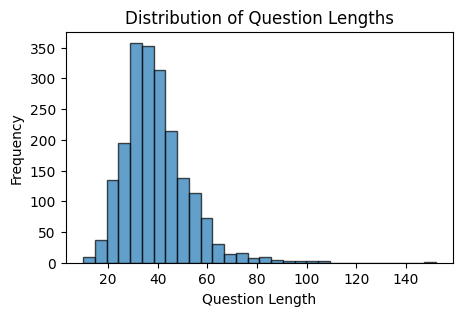

In [8]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

## Feature Engineering using TF-IDF

- TF-IDF 참고 링크: https://ko.wikipedia.org/wiki/Tf-idf

### Initialize TF-IDF Vectorizer

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

### Fit and transform the text data

In [10]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_question'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

### Display the TF-IDF features

In [11]:
print("\nTF-IDF Features:")
display(tfidf_df.head(20))


TF-IDF Features:


11월  12월  1450  1450년에서  1750  1750년  17세기  1800년대  1860년  1960년대  1999년  \
0   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
1   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
2   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
3   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
4   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
5   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
6   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
7   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
8   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
9   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
10  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
11  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
12  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
13  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
14  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
15  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
16  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
17  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
18  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
19  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   

    19세기  1분기   1월   1위  1위를   1의  2008년  2010년  2013년  2014  2014년  2014년도  \
0    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
5    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
6    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
7    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
8    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
9    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
10   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
11   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
12   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
13   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
14   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
15   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
16   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
17   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
18   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
19   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   

    2015학년도  2019  2019년  2020  2020년  20세기  2분기  2에서  3분기   5년   5월  600  \
0       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7       0.0   0.0    0.0   0.0    0.0   0.0  0.

## Model Training

### Baseline Model

- https://huggingface.co/beomi/gemma-ko-2b

In [ ]:
# 본인의 Huggingface auth token 입력
## Jupyter lab에서 로그인 하는 textbox가 나오지 않을 경우, terminal에서 로그인 하실 수 있습니다.
!huggingface-cli login

모델과 토크나이저를 불러옵니다.

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "beomi/gemma-ko-2b",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    "beomi/gemma-ko-2b",
    trust_remote_code=True,
)

gemma-ko-2b 모델에는 chat template 이 없기 때문에 직접 입력해주어야 합니다.

In [14]:
tokenizer.chat_template = "{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}{% if system_message is defined %}{{ system_message }}{% endif %}{% for message in messages %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<start_of_turn>user\n' + content + '<end_of_turn>\n<start_of_turn>model\n' }}{% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>\n' }}{% endif %}{% endfor %}"

### Prepare LoRA

In [15]:
peft_config = LoraConfig(
    r=6,
    lora_alpha=8,
    lora_dropout=0.05,
    target_modules=['q_proj', 'k_proj'],
    bias="none",
    task_type="CAUSAL_LM",
)

### Data Processing

In [16]:
dataset = Dataset.from_pandas(df)

In [17]:
PROMPT_NO_QUESTION_PLUS = """지문:
{paragraph}

배경 지식:
{document}

질문:
{question}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

PROMPT_QUESTION_PLUS = """지문:
{paragraph}

배경 지식:
{document}

질문:
{question}

<보기>:
{question_plus}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

In [18]:
dataset

Dataset({
    features: ['id', 'paragraph', 'question', 'choices', 'answer', 'question_plus', 'full_question', 'question_length'],
    num_rows: 2031
})

### Sparse Retriever

In [19]:
from konlpy.tag import Mecab
import bm25s

# tqdm과 pandas 결합
tqdm.pandas()

# Mecab 객체 생성
mecab = Mecab()

In [20]:
# 저장된 BM25 인덱스 로드
print("Loading BM25 index and document data...")
retriever = bm25s.BM25.load("wikipedia_index_bm25", load_corpus=True)
print("BM25 index and document data successfully loaded.")

Loading BM25 index and document data...
BM25 index and document data successfully loaded.


#### RAG 배경지식 추가

In [ ]:
processed_dataset = []
for i in range(len(dataset)):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(dataset[i]["choices"])])
    query = dataset[i]["paragraph"]
    query_tokens = bm25s.tokenize(' '.join(mecab.morphs(query)))
    results, scores = retriever.retrieve(query_tokens, k=5)
    docs = "\n".join(item['text'] for sublist in results for item in sublist)

    # <보기>가 있을 때
    if dataset[i]["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            document=docs,
            question=dataset[i]["question"],
            question_plus=dataset[i]["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            document=docs,
            question=dataset[i]["question"],
            choices=choices_string,
        )

    # chat message 형식으로 변환
    processed_dataset.append(
        {
            "id": dataset[i]["id"],
            "messages": [
                {"role": "system", "content": """당신은 수능 문제 출제 의원입니다. 
    1. 지문을 꼼꼼히 읽고 핵심 내용을 파악하세요
    2. 질문의 의도를 정확히 이해하세요
    3. 주어진 배경 지식을 보조 자료로 활용하세요
    4. 논리적인 근거를 바탕으로 가장 적절한 답을 구하세요"""},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": f"{dataset[i]['answer']}"}
            ],
            "label": dataset[i]["answer"],
        }
    )


In [ ]:
processed_dataset[0]

In [23]:
processed_dataset = Dataset.from_pandas(pd.DataFrame(processed_dataset))
processed_dataset

Dataset({
    features: ['id', 'messages', 'label'],
    num_rows: 2031
})

In [24]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["messages"])):
        output_texts.append(
            tokenizer.apply_chat_template(
                example["messages"][i],
                tokenize=False,
            )
        )
    return output_texts

def tokenize(element):
    outputs = tokenizer(
        formatting_prompts_func(element),
        truncation=False,
        padding=False,
        return_overflowing_tokens=False,
        return_length=False,
    )
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

# 데이터 토큰화
tokenized_dataset = processed_dataset.map(
    tokenize,
    remove_columns=list(processed_dataset.features),
    batched=True,
    num_proc=4,
    load_from_cache_file=True,
    desc="Tokenizing",
)

Tokenizing (num_proc=4):   0%|          | 0/2031 [00:00<?, ? examples/s]

In [ ]:
# 데이터 분리
# vram memory 제약으로 인해 인풋 데이터의 길이가 2048 초과인 데이터는 제외하였습니다. *힌트: 2048보다 길이가 더 긴 데이터를 포함하면 더 높은 점수를 달성할 수 있을 것 같습니다!
tokenized_dataset = tokenized_dataset.filter(lambda x: len(x["input_ids"]) <= 2048)  
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['test']
# 데이터 확인
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=True))

In [ ]:
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=False))

In [27]:
train_dataset_token_lengths = [len(train_dataset[i]["input_ids"]) for i in range(len(train_dataset))]
print(f"max token length: {max(train_dataset_token_lengths)}")
print(f"min token length: {min(train_dataset_token_lengths)}")
print(f"avg token length: {np.mean(train_dataset_token_lengths)}")

max token length: 2048
min token length: 352
avg token length: 1360.8441802252817


In [34]:
len(train_dataset)

1598

In [35]:
len(eval_dataset)

178

In [28]:
print(tokenizer.chat_template)

{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}{% if system_message is defined %}{{ system_message }}{% endif %}{% for message in messages %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<start_of_turn>user
' + content + '<end_of_turn>
<start_of_turn>model
' }}{% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>
' }}{% endif %}{% endfor %}


Completion 부분만 학습하기 위한 data collator 설정

- 텍스트 중 response_template 까지는 ignore_index 로 loss 계산에서 제외
- 텍스트 중 response_template 이후는 학습에 포함 (정답 + eos 토큰)

In [29]:
response_template = "<start_of_turn>model"
data_collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template,
    tokenizer=tokenizer,
)

### Metric 설정

In [30]:
# 모델의 logits 를 조정하여 정답 토큰 부분만 출력하도록 설정
def preprocess_logits_for_metrics(logits, labels):
    logits = logits if not isinstance(logits, tuple) else logits[0]
    logit_idx = [tokenizer.vocab["1"], tokenizer.vocab["2"], tokenizer.vocab["3"], tokenizer.vocab["4"], tokenizer.vocab["5"]]
    logits = logits[:, -2, logit_idx] # -2: answer token, -1: eos token
    return logits

# metric 로드
acc_metric = evaluate.load("accuracy")

# 정답 토큰 매핑
int_output_map = {"1": 0, "2": 1, "3": 2, "4": 3, "5": 4}

# metric 계산 함수
def compute_metrics(evaluation_result):
    logits, labels = evaluation_result

    # 토큰화된 레이블 디코딩
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    labels = list(map(lambda x: x.split("<end_of_turn>")[0].strip(), labels))
    labels = list(map(lambda x: int_output_map[x], labels))

    # 소프트맥스 함수를 사용하여 로그트 변환
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)
    predictions = np.argmax(probs, axis=-1)

    # 정확도 계산
    acc = acc_metric.compute(predictions=predictions, references=labels)
    return acc

### Train

In [31]:
# pad token 설정
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.special_tokens_map

{'bos_token': '<bos>',
 'eos_token': '<eos>',
 'unk_token': '<unk>',
 'pad_token': '<eos>'}

In [32]:
tokenizer.padding_side = 'right'

sft_config = SFTConfig(
    do_train=True,
    do_eval=True,
    lr_scheduler_type="cosine",
    max_seq_length=2048,
    output_dir="outputs_gemma",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=1,
    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=2,
    save_only_model=True,
    report_to="none",
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    peft_config=peft_config,
    args=sft_config,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [36]:
%%time

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.225900,0.112309,0.455056
2,0.002900,0.118490,0.466292
3,0.000100,0.116678,0.460674


CPU times: user 28min 59s, sys: 6min 35s, total: 35min 35s
Wall time: 35min 45s


TrainOutput(global_step=4794, training_loss=0.11671272242113077, metrics={'train_runtime': 2144.9824, 'train_samples_per_second': 2.235, 'train_steps_per_second': 2.235, 'total_flos': 7.760459572643635e+16, 'train_loss': 0.11671272242113077, 'epoch': 3.0})

## Inference

In [ ]:
# TODO 학습된 Checkpoint 경로 입력
checkpoint_path = "outputs_gemma/checkpoint-4794"

model = AutoPeftModelForCausalLM.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
    # torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
)

In [45]:
# Load the test dataset
# TODO Test Data 경로 입력
test_df = pd.read_csv('/data/ephemeral/home/bsw/data/test.csv')

# Flatten the JSON dataset
records = []
for _, row in test_df.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
test_df = pd.DataFrame(records)

#### RAG 배경지식 추가

In [ ]:
test_dataset = []
for i, row in test_df.iterrows():
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(row["choices"])])
    len_choices = len(row["choices"])
    
    query = dataset[i]["paragraph"]
    query_tokens = bm25s.tokenize(' '.join(mecab.morphs(query)))
    results, scores = retriever.retrieve(query_tokens, k=5)
    docs = "\n".join(item['text'] for sublist in results for item in sublist)
    
    # <보기>가 있을 때
    if row["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            document=docs,
            question=row["question"],
            question_plus=row["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            document=docs,
            question=row["question"],
            choices=choices_string,
        )

    test_dataset.append(
        {
            "id": row["id"],
            "messages": [
                {"role": "system", "content": """당신은 수능 문제 출제 의원입니다. 
    1. 지문을 꼼꼼히 읽고 핵심 내용을 파악하세요
    2. 질문의 의도를 정확히 이해하세요
    3. 주어진 배경 지식을 보조 자료로 활용하세요
    4. 논리적인 근거를 바탕으로 가장 적절한 답을 구하세요"""},
                {"role": "user", "content": user_message},
            ],
            "label": row["answer"],
            "len_choices": len_choices,
        }
    )

In [47]:
%%time

infer_results = []

pred_choices_map = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5"}

model.eval()
with torch.inference_mode():
    for data in tqdm(test_dataset):
        _id = data["id"]
        messages = data["messages"]
        len_choices = data["len_choices"]

        outputs = model(
            tokenizer.apply_chat_template(
                messages,
                tokenize=True,
                add_generation_prompt=True,
                return_tensors="pt",
            ).to("cuda")
        )

        logits = outputs.logits[:, -1].flatten().cpu()

        target_logit_list = [logits[tokenizer.vocab[str(i + 1)]] for i in range(len_choices)]

        probs = (
            torch.nn.functional.softmax(
                torch.tensor(target_logit_list, dtype=torch.float32)
            )
            .detach()
            .cpu()
            .numpy()
        )

        predict_value = pred_choices_map[np.argmax(probs, axis=-1)]
        row = {"id": _id, "answer": predict_value}
                
        target_logit_list = [logit.item() for logit in target_logit_list]
        if len_choices < len(pred_choices_map):
            target_logit_list += [None] * (len(pred_choices_map) - len_choices)
        for i, logit in enumerate(target_logit_list):
            row[f"logit_{pred_choices_map[i]}"] = logit

        infer_results.append(row)

100%|██████████| 869/869 [24:10<00:00,  1.67s/it]

CPU times: user 21min 15s, sys: 2min 55s, total: 24min 11s
Wall time: 24min 10s


In [48]:
pd.DataFrame(infer_results).to_csv("output.csv", index=False)

In [49]:
pd.DataFrame(infer_results)

,id,answer,logit_1,logit_2,logit_3,logit_4,logit_5
0,generation-for-nlp-0,1,23.035927,21.516104,20.274733,21.454302,18.313000
1,generation-for-nlp-1,1,23.338442,22.922279,22.218512,22.584602,21.040928
2,generation-for-nlp-2,4,19.119200,18.344103,17.927185,21.016123,17.819260
3,generation-for-nlp-3,4,20.940685,20.255058,20.867828,21.345648,18.240198
4,generation-for-nlp-4,1,23.408834,23.281528,21.031822,22.006548,20.537416
...,...,...,...,...,...,...,...
864,generation-for-nlp-1609,1,22.298765,15.832126,14.632318,13.394604,13.313965
865,generation-for-nlp-1512,1,24.121782,15.435970,14.558787,15.525492,15.092356
866,generation-for-nlp-1382,3,17.153818,16.798748,21.948103,15.059010,14.046880
867,generation-for-nlp-702,2,21.499445,21.772877,20.981718,21.418108,NaN
